In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import scipy.integrate as spi
import pylab as pl


from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.signal import savgol_filter
import operator
#from pyDOE import *
from mpl_toolkits.mplot3d import Axes3D
from pylab import *

In [2]:
coinf_timeseries=np.loadtxt("coinf_timeseries.csv")
measles_timeseries=np.loadtxt("measles_timeseries.csv")

In [19]:
def coinf_tempimmunity_model(INP,t,ps):  
    try:
#         beta0=ps['beta0'].value
#         beta1=ps['beta1'].value

#         gamma0=ps['gamma0'].value
#         gamma1=ps['gamma1'].value
        c1=ps['c1'].value
        c2=ps['c2'].value
        c3=ps['c3'].value

        
#       sigma=ps['sigma'].value
#         omega=ps['omega'].value
#         delta0=ps['delta0'].value

    except:
        #beta0,beta1,gamma0,gamma1,c1,c2,c3,sigma,omega,delta0
        c1,c2,c3=ps
    N=2618
    
    mu=np.array([c1*omega,c2*omega,c3*gamma1,])
    beta=np.hstack((beta0/N,beta1/N))

    
    Y=np.zeros((15))
    V = INP    
    
    infect_0=(V[1]+V[4]+V[7]+V[9]+V[11])
    infect_1=(V[6]+V[7])
    
    #susceptible to measles
    Y[0]=-beta[1]*V[0]*infect_1-beta[0]*V[0]*infect_0+delta0*V[2]

    Y[1]=-beta[1]*V[1]*infect_1+beta[0]*V[0]*infect_0-gamma0*V[1]

    Y[2]=-beta[1]*V[2]*infect_1+gamma0*V[1]-delta0*V[2]


    #exposed to measles
    Y[3]=beta[1]*V[0]*infect_1-sigma*V[3]-beta[0]*V[3]*infect_0+delta0*V[5]

    Y[4]=beta[1]*V[1]*infect_1-sigma*V[4]+beta[0]*V[3]*infect_0-gamma0*V[4]

    Y[5]=beta[1]*V[2]*infect_1-sigma*V[5]+gamma0*V[4]-delta0*V[5]


    #infected with measles
    Y[6]=sigma*V[3]+sigma*V[5]-mu[0]*V[6]-omega*Y[6]-beta[0]*V[6]*infect_0
    
    Y[7]=sigma*V[4]-mu[1]*V[7]-omega*Y[7]+beta[0]*V[6]*infect_0

   


    #immunosuppressed with measles
    Y[8]=omega*Y[6]-gamma1*Y[8]-beta[0]*V[8]*infect_0

    Y[9]=omega*Y[7]-gamma1*Y[9]-mu[2]*V[9]+beta[0]*V[8]*infect_0

    


    #recovered from measles
    Y[10]=gamma1*Y[8]-beta[0]*V[10]*infect_0+delta0*V[12]

    Y[11]=gamma1*Y[9]+beta[0]*V[10]*infect_0-gamma0*V[11]

    Y[12]=gamma0*V[11]-delta0*V[12]



    Y[13]=mu[0]*V[6]
    Y[14]=mu[1]*V[7]+mu[2]*V[9]

    
    return Y   # For odeint


In [20]:
def residual(ps,INP, ts, data):
    IS=ps['IS'].value
#     N=2618
#     beta=ps['beta0'].value
#     gamma=ps['gamma0'].value
#     IS=(1-(gamma/beta))*N
    INP=(N-IS-2,IS,0,0,0,0,2,0,0,0,0,0,0,0,0)
    RES = spi.odeint(coinf_tempimmunity_model,INP,ts,args=(ps,))
    res_measles=RES[1:ts_len+1,13]-RES[0:ts_len,13]
    res_coinf=RES[1:ts_len+1,14]-RES[0:ts_len,14]
    model=np.array((res_measles,res_coinf))

    return (model - data).ravel()

In [32]:
N=2618
#sigma=1/14
IS0=2617
RS0=0
SE0=0
IE0=0
RE0=0
SI0=2
II0=0
SX0=0
IX0=0
SR0=0
IR0=0
RR0=0
SS0=N-IS0-SE0-SI0
INPUT=(SS0,IS0,RS0,SE0,IE0,RE0,SI0,II0,SX0,IX0,SR0,IR0,RR0,0,0)
ts_len=len(measles_timeseries)
delta0=1.0
beta0=   2.49169218 
beta1=   0.47460927 
gamma0=  0.13810335 
gamma1=  0.13857085 

sigma=  0.10880413 
omega=   0.13376418 
#IS:      2617.99954 


TS=1.0
ND=float(ts_len+1)
t_start = 0.0; t_end = ND; t_inc = TS
t_range = np.arange(t_start, t_end+t_inc, t_inc)


time_series=np.array((measles_timeseries,coinf_timeseries))


# set parameters incluing bounds
params = Parameters()
# params.add('beta0',value=1.2,min=0.001,max=3)
# params.add('beta1',value=1,min=(2/13),max=(20/6))
# params.add('gamma0',value=0.1,min=0.005,max=0.9)
# params.add('gamma1',value=0.1,min=0.01,max=2)
params.add('c1',value=0.1,min=0.001,max=0.5)
params.add('c2',value=0.1,min=0.001,max=0.5)
params.add('c3',value=0.1,min=0.001,max=0.5)
# params.add('sigma',value=0.1,min=1/21,max=1/7)
# params.add('omega',value=0.1,min=1/13,max=1/6)


params.add('IS',value=600,min=1,max=2618)

# fit model and find predicted values
result = minimize(residual, params, args=(INPUT,t_range, time_series), method='leastsq')
#result = minimize(residual, params, args=(INPUT,t_range, time_series), method='lbfgsb' )
final = time_series + result.residual.reshape(time_series.shape)


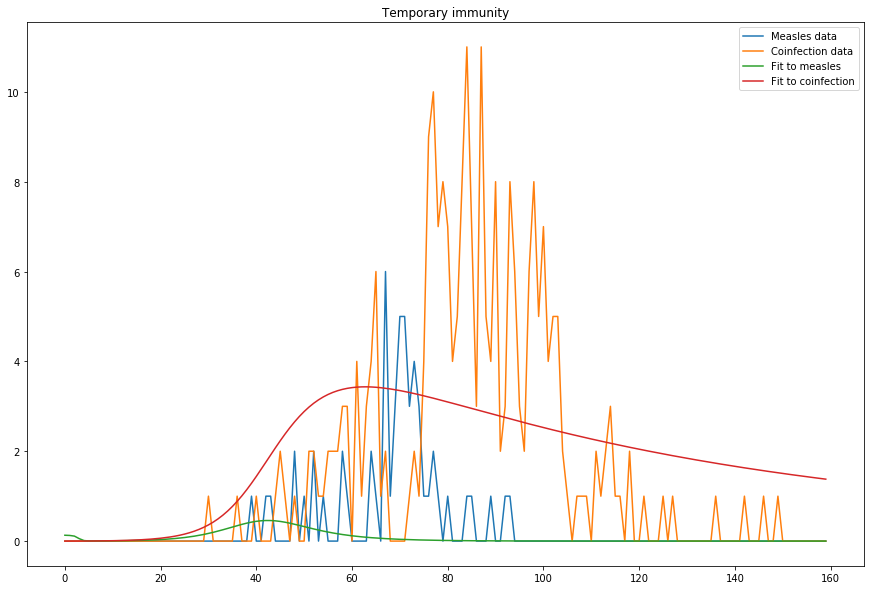

In [33]:
plt.figure(figsize=(15,10))

plt.plot(time_series[0],label="Measles data")
plt.plot(time_series[1],label="Coinfection data")
plt.plot(final[0],label="Fit to measles")
plt.plot(final[1],label="Fit to coinfection")

plt.title('Temporary immunity')

plt.legend()
plt.show()

In [34]:
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 87
    # data points      = 320
    # variables        = 4
    chi-square         = 905.356228
    reduced chi-square = 2.86505135
    Akaike info crit   = 340.802397
    Bayesian info crit = 355.875681
[[Variables]]
    c1:  0.49995290 +/- 0.01695737 (3.39%) (init = 0.1)
    c2:  0.00100205 +/- 1.1496e-04 (11.47%) (init = 0.1)
    c3:  0.08878543 +/- 0.01031917 (11.62%) (init = 0.1)
    IS:  1.09373125 +/- 27.7887624 (2540.73%) (init = 600)
[[Correlations]] (unreported correlations are < 0.100)
    C(c1, IS) = -0.186
    C(c1, c3) =  0.157
    C(c2, c3) = -0.139


In [16]:
def tempimmunity_model(INP,t):  

    N=2618
    
    mu=np.array([c1*omega,c2*omega,c3*gamma1,])
    beta=np.hstack((beta0/N,beta1/N))

    
    Y=np.zeros((15))
    V = INP    
    
    infect_0=(V[1]+V[4]+V[7]+V[9]+V[11])
    infect_1=(V[6]+V[7])
    
    #susceptible to measles
    Y[0]=-beta[1]*V[0]*infect_1-beta[0]*V[0]*infect_0+delta0*V[2]

    Y[1]=-beta[1]*V[1]*infect_1+beta[0]*V[0]*infect_0-gamma0*V[1]

    Y[2]=-beta[1]*V[2]*infect_1+gamma0*V[1]-delta0*V[2]


    #exposed to measles
    Y[3]=beta[1]*V[0]*infect_1-sigma*V[3]-beta[0]*V[3]*infect_0+delta0*V[5]

    Y[4]=beta[1]*V[1]*infect_1-sigma*V[4]+beta[0]*V[3]*infect_0-gamma0*V[4]

    Y[5]=beta[1]*V[2]*infect_1-sigma*V[5]+gamma0*V[4]-delta0*V[5]


    #infected with measles
    Y[6]=sigma*V[3]+sigma*V[5]-mu[0]*V[6]-omega*Y[6]-beta[0]*V[6]*infect_0
    
    Y[7]=sigma*V[4]-mu[1]*V[7]-omega*Y[7]+beta[0]*V[6]*infect_0

   


    #immunosuppressed with measles
    Y[8]=omega*Y[6]-gamma1*Y[8]-beta[0]*V[8]*infect_0

    Y[9]=omega*Y[7]-gamma1*Y[9]-mu[2]*V[9]+beta[0]*V[8]*infect_0

    


    #recovered from measles
    Y[10]=gamma1*Y[8]-beta[0]*V[10]*infect_0+delta0*V[12]

    Y[11]=gamma1*Y[9]+beta[0]*V[10]*infect_0-gamma0*V[11]

    Y[12]=gamma0*V[11]-delta0*V[12]



    Y[13]=mu[0]*V[6]
    Y[14]=mu[1]*V[7]+mu[2]*V[9]

    
    return Y   # For odeint


In [26]:
N=2618
#sigma=1/14
IS0=2617
RS0=0
SE0=0
IE0=0
RE0=0
SI0=2
II0=0
SX0=0
IX0=0
SR0=0
IR0=0
RR0=0
SS0=N-IS0-SE0-SI0
INPUT=(SS0,IS0,RS0,SE0,IE0,RE0,SI0,II0,SX0,IX0,SR0,IR0,RR0,0,0)
ts_len=len(measles_timeseries)
delta0=1.0
beta0=   2.49169218 
beta1=   0.47460927 
gamma0=  0.13810335 
gamma1=  0.13857085 

sigma=  0.10880413 
omega=   0.13376418 
IS=    670

c1=0.3
c2=0.01
c3=0.2

TS=1.0
ND=float(ts_len+1)
t_start = 0.0; t_end = ND; t_inc = TS
t_range = np.arange(t_start, t_end+t_inc, t_inc)

RES = spi.odeint(tempimmunity_model,INPUT,t_range)
res_measles=RES[1:ts_len+1,13]-RES[0:ts_len,13]
res_coinf=RES[1:ts_len+1,14]-RES[0:ts_len,14]


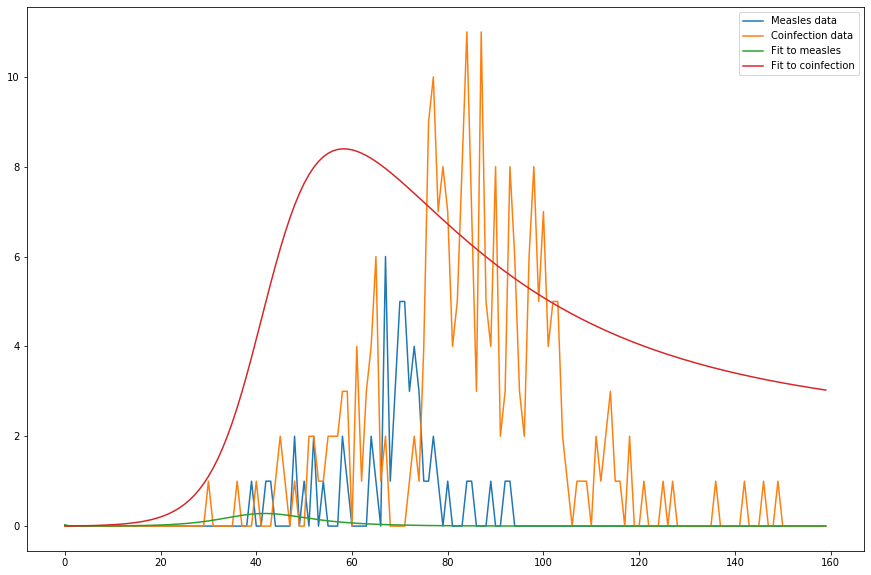

In [27]:
plt.figure(figsize=(15,10))

plt.plot(time_series[0],label="Measles data")
plt.plot(time_series[1],label="Coinfection data")
plt.plot(res_measles,label="Fit to measles")
plt.plot(res_coinf,label="Fit to coinfection")


plt.legend()
plt.show()